### 1. Import and data loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

In [2]:
df = pd.read_csv("../data/chess_games_feature.csv")
df.head()

,WhiteElo,BlackElo,ResultNumeric,EventTypeID,RatingDiff,AvgRating,WhiteIsHigherRated,WhiteRatingAdvantage,ECOID,w_material_early,...,w_castled_early,b_castled_early,w_checks_early,b_checks_early,early_checks,w_piece_activity,b_piece_activity,both_castled_early,total_captures_early,activity_diff
0,2504,2371,2,0,133,2437.5,1,133,0,38.0,...,1.0,1.0,0.0,0.0,0.0,34.0,35.0,1,2.0,-1.0
1,2487,2596,1,0,109,2541.5,0,-109,0,38.0,...,1.0,1.0,0.0,1.0,1.0,34.0,40.0,1,1.0,-6.0
2,2915,2921,1,0,6,2918.0,0,-6,0,38.0,...,1.0,1.0,0.0,0.0,0.0,36.0,38.0,1,2.0,-2.0
3,2542,2433,2,0,109,2487.5,1,109,10,35.0,...,1.0,0.0,1.0,0.0,1.0,45.0,33.0,0,5.0,12.0
4,2473,2658,0,0,185,2565.5,0,-185,0,33.0,...,1.0,1.0,1.0,0.0,1.0,34.0,33.0,1,4.0,1.0


### 2. Prepare data

In [3]:
X = df.drop(['ResultNumeric'], axis=1)
y = df['ResultNumeric']

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

Features: (3243955, 33)
Target: (3243955,)


### 3. Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 20% for testing
    random_state=42,
    stratify=y
)

### 4. Train model

In [5]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

In [6]:
start_time = time.time()

xgb_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Training completed in 33.67 seconds (0.56 minutes)


### 5. Evaluate

In [7]:
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest Set Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Black Win', 'Draw', 'White Win']))


Test Set Accuracy: 0.5855 (58.55%)

Classification Report:

              precision    recall  f1-score   support

   Black Win       0.56      0.58      0.57    265868
        Draw       0.87      0.27      0.41     83919
   White Win       0.59      0.68      0.63    299004

    accuracy                           0.59    648791
   macro avg       0.67      0.51      0.54    648791
weighted avg       0.61      0.59      0.58    648791



### 6. Confusion Matrix

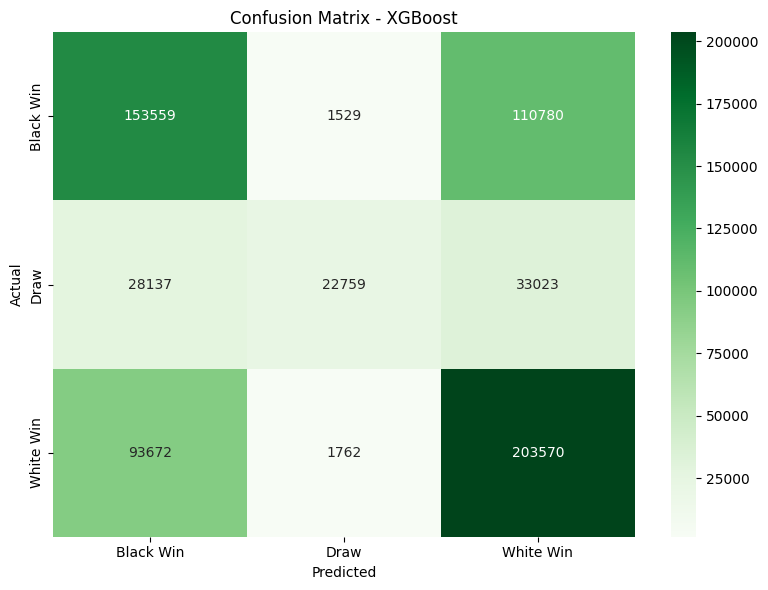

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Black Win', 'Draw', 'White Win'],
            yticklabels=['Black Win', 'Draw', 'White Win'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - XGBoost')
plt.tight_layout()
plt.show()

### 7. Feature Importance

                  Feature  Importance
4               AvgRating    0.318500
6    WhiteRatingAdvantage    0.304882
3              RatingDiff    0.089588
0                WhiteElo    0.067898
1                BlackElo    0.060902
2             EventTypeID    0.037783
30     both_castled_early    0.014254
5      WhiteIsHigherRated    0.013485
8        w_material_early    0.009167
31   total_captures_early    0.008586
9        b_material_early    0.007031
20          w_development    0.005261
10    material_diff_early    0.004939
24        b_castled_early    0.004688
32          activity_diff    0.004390
23        w_castled_early    0.004274
21          b_development    0.004214
15     b_aggression_early    0.003991
7                   ECOID    0.003562
11       w_captures_early    0.003489
13     capture_diff_early    0.003376
26         b_checks_early    0.002552
29       b_piece_activity    0.002355
25         w_checks_early    0.002338
16  aggression_diff_early    0.002299
12       b_c

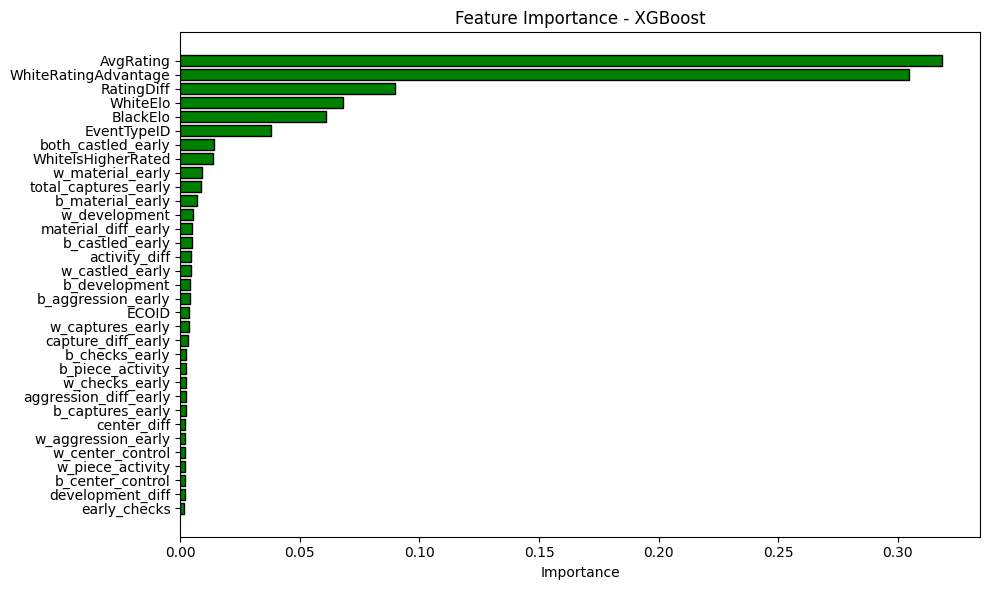

In [9]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='green', edgecolor='black')
plt.xlabel('Importance')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()